In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import numpy as np
import numpy.random as rd
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import random
import torch.utils.data as data_utils
from sklearn.decomposition import PCA # function for doing PCA in one line of code!

In [3]:
#load stimuli
%cd /content/gdrive/My Drive/RNN/
stim_all= torch.tensor(np.loadtxt("2backRNN_trainStim.txt")).float()
targets_all= torch.tensor(np.loadtxt("2backRNN_trainTarget.txt")).float()

/content/gdrive/My Drive/RNN


In [4]:
class LSTM(nn.Module):
    def __init__(self, input_size, n_hidden, n_layer):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, n_hidden, n_layer)
        self.out = nn.Linear(n_hidden, 1)
    def forward(self, input):
        h, _ = self.lstm(input)
        y = self.out(torch.relu(h))
        #y = self.out(h)
        return h, y.squeeze().transpose(dim0=1, dim1=0)

# Squared error loss function (MSE)
def loss_fn(outputs, targets): 
    acc = torch.zeros(outputs.size(0))
    total_err = torch.zeros(1)
    resp_tp = np.arange(6,n_timestep,3)
    n_resp = n_stim - 2


    for i in range(outputs.size(0)): #batch
        batch_err = torch.zeros(1)
        batch_acc = 0

        for j in resp_tp: #timepoints
            batch_err += (targets[i,j] - outputs[i,j])**2/n_resp
            err = (targets[i,j] - outputs[i,j]).detach().numpy()
            if np.absolute(err) < 0.5:
                batch_acc += 1/n_resp
        total_err += batch_err
        acc[i] = batch_acc
    return total_err, acc

In [5]:
# Run LSTM
n_hidden =  7
batch_size = 20
n_layer = 1
input_size = 6
n_stim = 20
n_timestep = 58
learning_rate = 1e-3 # 1e-5
n_iter = 5000 # iterations of SGD, 500
batch_size = 20
n_timestep = 58
n_sequence = 200
#track_targets = np.zeros(n_iter * batch_size)
#track_outputs = np.zeros(n_iter * batch_size)

track_loss = np.zeros(n_iter)
model2 = LSTM(input_size, n_hidden, n_layer)
optimizer = optim.Adam(model2.parameters(), lr=learning_rate) # it was model before!!!!
np.random.seed()

# Loop over iterations
t = 0
for i in range(n_iter):
    if (i + 1) %  250 == 0: # print progress every 100 iterations
        print('%.2f%% iterations of Adam completed...loss = %.2f'  % (100* (i + 1) / n_iter, loss*10))
    input_mat = torch.zeros(n_timestep,batch_size, 6)
    batch_idx = np.random.choice(n_sequence, batch_size)
    stim, targets = stim_all[batch_idx,:], targets_all[batch_idx,:]

    for i in range(batch_size):
        for j in range(n_timestep):
            if (j+1)%3==1:
                input_mat[j,i,int(stim[i,j])] = 1  #activate the stimulus unit

    hidden, outputs = model2.forward(input_mat)  #LSTM model
    loss, acc = loss_fn(outputs, targets)
    track_loss[t] = loss 
   # Compute gradients
    optimizer.zero_grad()
    loss.backward()
   # Update weights
    optimizer.step()
    t += 1

5.00% iterations of Adam completed...loss = 43.93
10.00% iterations of Adam completed...loss = 42.13
15.00% iterations of Adam completed...loss = 43.15
20.00% iterations of Adam completed...loss = 42.22
25.00% iterations of Adam completed...loss = 38.95
30.00% iterations of Adam completed...loss = 35.62
35.00% iterations of Adam completed...loss = 27.06
40.00% iterations of Adam completed...loss = 22.88
45.00% iterations of Adam completed...loss = 18.97
50.00% iterations of Adam completed...loss = 17.24
55.00% iterations of Adam completed...loss = 13.08
60.00% iterations of Adam completed...loss = 11.13
65.00% iterations of Adam completed...loss = 9.50
70.00% iterations of Adam completed...loss = 7.70
75.00% iterations of Adam completed...loss = 6.25
80.00% iterations of Adam completed...loss = 4.68
85.00% iterations of Adam completed...loss = 4.66
90.00% iterations of Adam completed...loss = 3.47
95.00% iterations of Adam completed...loss = 2.67
100.00% iterations of Adam completed...

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
tensor(1.)


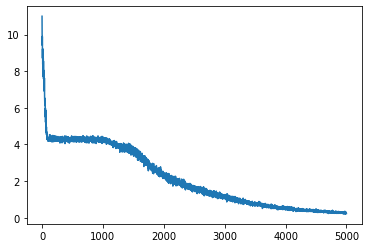

In [6]:
print(acc)
print(sum(acc)/20)
plt.plot(track_loss)

In [10]:
#test network (with new test stim)

n_timestep = 58
n_sequence = 200
stim = torch.tensor(np.loadtxt("2B_test_200_stim.txt")).float() #1 is 2back
targets = torch.tensor(np.loadtxt("2B_test_200_targ.txt")).float()
# stim = stim[:30,:]
# targets= targets[:30,:]
stim, targets = stim_all, targets_all
batch_size = n_sequence #50
input_mat = torch.zeros(n_timestep, batch_size, 6)
#batch_idx = np.random.choice(n_sequence, batch_size)
#stim_00, targets_00 = stim_0[batch_idx,:], targets_0[batch_idx,:] # 2back #############
#stim_01, targets_01 = stim_1[batch_idx,:], targets_1[batch_idx,:]########

for i in range(batch_size):
    for j in range(n_timestep):
        if (j+1)%3==1:
            input_mat[j,i,int(stim[i,j])] = 1  #activate the stimulus unit
hidden, outputs = model2.forward(input_mat)
loss, acc = loss_fn(outputs, targets)
print(loss)
# print(acc)
print(sum(acc)/200)

tensor([2.6132], grad_fn=<AddBackward0>)
tensor(0.9997)


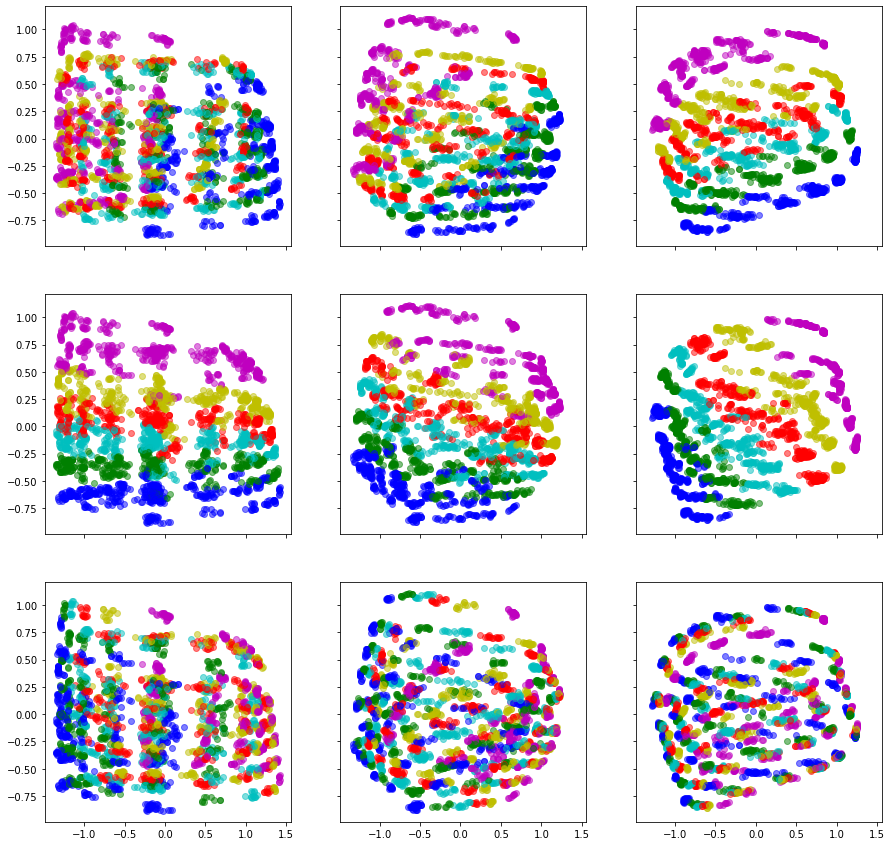

In [9]:
#######################   PCA of hidden layer activations (colored by stimulus n)  ###################
fig, axs = plt.subplots(3, 3, figsize=(3*5, 3*5), sharex=True, sharey=True) #2 rows and 3 columns: 2, 3, figsize=(3*5, 2*5)

# Set up PCA
pca = PCA(n_components=2) # reduce dimensionality to 2

# Choose stimuli whose representations to plot and colors to plot them with
plot_digits = [0,1,2,3,4,5]
plot_colors = ['r', 'b', 'g','y', 'm', 'c']

# Do PCA on activations, and plot the dimensionality-reduced activations 
hid_2d = np.reshape(hidden.transpose(dim0=1,dim1=0).detach().numpy(), (-1, n_hidden))
stim_2d = np.reshape(stim.detach().numpy(),(-1))
pc_activity = pca.fit_transform(hid_2d) 

for t_move in range(9):#np.array([0,1,2,3]):##([0,1,2,3]):#([0,1,2,3]):#([4,5,6,7]):#

    tp0 = np.arange(6,51,3) + t_move #for DR #(6,51,3)
    for bnum in range(batch_size):
        if bnum == 0:
            tps = tp0 #6 is third stimulus, 54 is (n-2)stimulus
        else:
            tps = np.concatenate((tps, tp0 + 58*bnum))

    for indx in tps:
        label = stim_2d[indx-t_move]
        for digit, color in zip(plot_digits, plot_colors):
            if label == digit:
                x, y = pc_activity[indx, 0], pc_activity[indx, 1]
                n = pc_activity.shape[0]
                if t_move < 3:
                    axs[0,t_move].plot(x, y, 'o', color=color, alpha=0.5)
                elif t_move < 6:
                    axs[1,t_move-3].plot(x, y, 'o', color=color, alpha=0.5)
                else:
                    axs[2,t_move-6].plot(x, y, 'o', color=color, alpha=0.5)